In [1]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 255)

In [3]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2023']:
        for month in ['4', '5', '6', '7', '8', '9', '10']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [4]:
len(subjects)

11841

In [5]:
data = pd.DataFrame(subjects)

# Formatting

In [8]:
def get_week_edition(data, focus_media, edition, week):
    week_start = datetime.date(year=2023, month=4, day=3) + datetime.timedelta(weeks=week)
    week_end = week_start + datetime.timedelta(days=8 if focus_media=='tf1' else 7)
    week_data = data[(data.media == focus_media)
                 & (data["date"] >= week_start.strftime("%Y-%m-%d")) 
                 & (data["date"] < week_end.strftime("%Y-%m-%d")) ].copy()

    # extract edition
    if focus_media == 'france2' and edition == "20h":
        week_data = week_data[['20h' in x for x in week_data.urlTvNews]].copy()
    if focus_media == 'france2' and edition == "13h":
        week_data = week_data[['13h' in x for x in week_data.urlTvNews]].copy()
    if focus_media == 'tf1' and edition == "20h":
        week_data = week_data[[('20h' in x) or ('we' in x and (d[11:13] >= "20" or d[11:13] <= "13")) for x,d in zip(week_data.urlTvNews, week_data.date)]].copy()

    
    # get subject
    if focus_media == 'tf1':
        topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
        week_data['topic'] = [topic_pattern.match(u).group(1) for u in week_data.url]
        
    if focus_media == 'france2':
        topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
        week_data['topic'] = [topic_pattern.match(u).group(1).split('/')[0] 
                                  for u in [x.replace('https://www.francetvinfo.frhttps://www.francetvinfo.fr', 'https://www.francetvinfo.fr') for x in week_data.url]]

    if focus_media == 'france2':
        week_data['formatted_date'] = [d.strftime('%d %B, %A') for d in pd.to_datetime(week_data.date)]  
    if focus_media == 'tf1':
        week_data['formatted_date'] = [(d - datetime.timedelta(hours=20)+datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(week_data.date)]
        week_data = week_data[(week_data['formatted_date'] >= week_start.strftime('%d %B, %A')) 
                                & (week_data['formatted_date'] < (week_end - datetime.timedelta(days=1)).strftime('%d %B, %A'))]
        
    return week_data

# Detection

In [13]:
tf1_all = []
for w in range(30):
    tf1_all.append(get_week_edition(data, 'tf1', '20h', w))

In [14]:
tf1_all = pd.concat(tf1_all)

In [15]:
len(tf1_all)

1528

In [17]:
france2_all = []
for w in range(30):
    france2_all.append(get_week_edition(data, 'france2', '20h', w))

In [18]:
france2_all = pd.concat(france2_all)

In [19]:
len(france2_all)

2534

In [32]:
keywords = {
    'A69' : ['a69', 'thomas brail']
}

In [21]:
topic = 'A69'

In [51]:
france2_all[['thomas brail' in (t+" "+d).lower() for t,d in zip(france2_all.title, france2_all.description)]][['formatted_date', 'title']]

,formatted_date,title
3352,"21 April, Friday",Autoroute : l’A69 entre Castres et Toulouse suscite la colère des militants écologistes
7143,"22 October, Sunday",Autoroute A69 : la tentative de ZAD avortée


In [42]:
tf1_all[[any([w in (t+" "+d).lower() for w in keywords[topic]]) for t,d in zip(tf1_all.title, tf1_all.description)]][['formatted_date', 'title']]

,formatted_date,title
8027,"05 April, Wednesday","VIDÉO - ZAD, campements illégaux... Ces sites à risques que les autorités surveillent de près"
7770,"22 April, Saturday",EN IMAGES - Projet d'autoroute A69 : une manifestation haute en couleurs mais sans heurts
11458,"22 October, Sunday","VIDEO - ZAD contre l'A69 : aussitôt créée, aussitôt évacuée"
11477,"16 October, Monday","VIDÉO - Toulouse-Castres : le chantier de l'A69 ira ""jusqu'à son terme"", malgré l'opposition des écologistes"


In [43]:
tf1_topic= {}

In [44]:
for topic in keywords.keys():
    if len(keywords[topic]) == 0:
        continue
    tf1_topic[topic] = tf1_all[[any([w in (t+" "+d).lower() for w in keywords[topic]]) for t,d in zip(tf1_all.title, tf1_all.description)]][['formatted_date', 'title', 'description', 'url']]

In [45]:
tf1_topic_counts = pd.Series({t:len(s) for t,s in tf1_topic.items()}).sort_values(ascending=False)

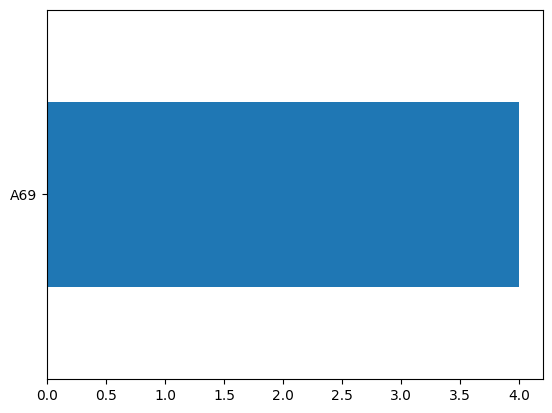

In [46]:
tf1_topic_counts.plot(kind='barh').invert_yaxis()

In [52]:
france_2_topic = {}

In [54]:
for topic in keywords.keys():
    if len(keywords[topic]) == 0:
        continue
    france_2_topic[topic] = france2_all[[any([w in (t+" "+d).lower() for w in keywords[topic]]) for t,d in zip(france2_all.title, france2_all.description)]][['formatted_date', 'title', 'description', 'url']]

In [55]:
france_2_topic_counts = pd.Series({t:len(s) for t,s in france_2_topic.items()}).sort_values(ascending=False)

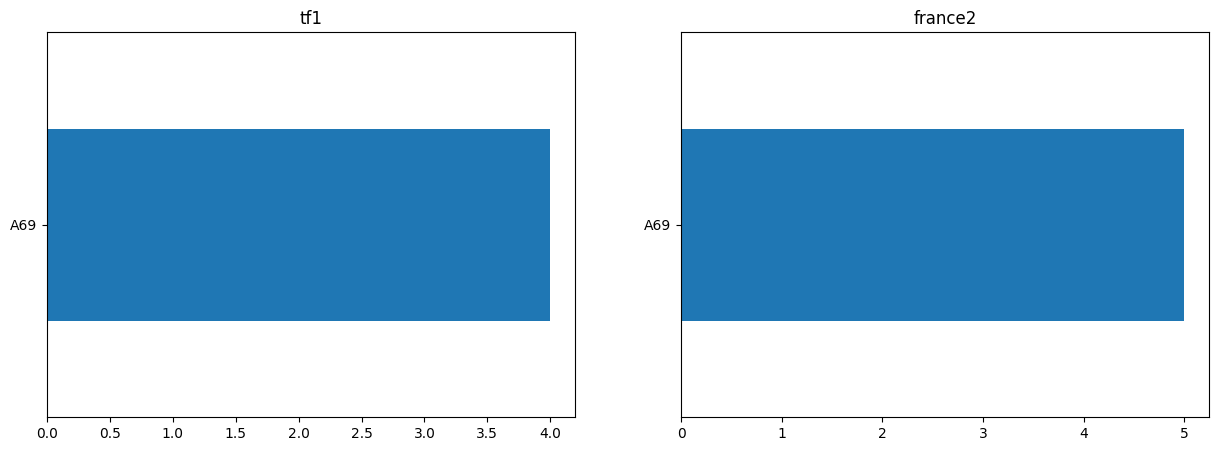

In [56]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tf1_topic_counts.plot(kind='barh', ax=axes[0], title='tf1', ylabel='').invert_yaxis()
france_2_topic_counts.plot(kind='barh', ax=axes[1], title='france2', ylabel='').invert_yaxis()

# Export

In [57]:
tf1_all.sort_values('date')[['formatted_date', 'title', 'description', 'url']].to_csv('data/a69_tf1_all.csv', index=False)

In [58]:
france2_all.sort_values('date')[['formatted_date', 'title', 'description', 'url']].to_csv('data/a69_france2_all.csv', index=False)

In [59]:
pd.concat(tf1_topic).reset_index().rename({'level_0': 'topic'}, axis=1).drop('level_1', axis=1).to_csv('data/a69_tf1_topics.csv', index=False)

In [60]:
pd.concat(france_2_topic).reset_index().rename({'level_0': 'topic'}, axis=1).drop('level_1', axis=1).to_csv('data/a69_france2_topics.csv', index=False)